<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Synthetic-Data---ARMA(1,1)" data-toc-modified-id="Synthetic-Data---ARMA(1,1)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Synthetic Data - ARMA(1,1)</a></span></li><li><span><a href="#Statsmodels" data-toc-modified-id="Statsmodels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statsmodels</a></span></li><li><span><a href="#PyMC" data-toc-modified-id="PyMC-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyMC</a></span><ul class="toc-item"><li><span><a href="#Prior-Predictive" data-toc-modified-id="Prior-Predictive-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Prior Predictive</a></span><ul class="toc-item"><li><span><a href="#Unconditional" data-toc-modified-id="Unconditional-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Unconditional</a></span></li><li><span><a href="#Conditional" data-toc-modified-id="Conditional-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Conditional</a></span></li></ul></li></ul></li><li><span><a href="#Estimation" data-toc-modified-id="Estimation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Estimation</a></span></li><li><span><a href="#Posterior-Predictive" data-toc-modified-id="Posterior-Predictive-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Posterior Predictive</a></span><ul class="toc-item"><li><span><a href="#Unconditional" data-toc-modified-id="Unconditional-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Unconditional</a></span></li><li><span><a href="#Conditional" data-toc-modified-id="Conditional-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Conditional</a></span></li></ul></li><li><span><a href="#Predictions-Compared" data-toc-modified-id="Predictions-Compared-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predictions Compared</a></span></li></ul></div>

In [1]:
%matplotlib inline
import sys

sys.path.append("..")

import jax

jax.config.update("jax_platform_name", "cpu")

import numpyro

numpyro.set_host_device_count(4)

import pymc as pm
import pytensor
from pytensor import tensor as pt

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import pymc_experimental.statespace as pmss

config = {
    "figure.figsize": [12.0, 4.0],
    "figure.dpi": 72.0 * 2,
    "figure.facecolor": "w",
    "axes.grid": True,
    "grid.linewidth": 0.5,
    "grid.linestyle": "--",
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

# Synthetic Data - ARMA(1,1)

Start very simple because I don't want to worry about stationarity at higher orders of p,q 

In [2]:
np.random.seed(1337)

AR_params = [0.8, 0.0]
MA_params = [-0.5]

# Initial state
x0 = np.r_[[0.0], [0.0]]

# Hidden state transition matrix
T = np.array([[AR_params[0], 1.0], [AR_params[1], 0.0]])

# Hidden state noise coefficients
R = np.array([[1.0], [MA_params[0]]])

# Hidden state covaraince matrix
Q = np.array([[0.8]])

# Observation matrix
Z = np.array([[1.0, 0.0]])

# Observation noise covariance
H = np.array([[0.0]])

timesteps = 100
data = np.zeros(timesteps)
hidden_states = np.zeros((timesteps, 2))
hidden_states[0, :] = x0

innovations = np.random.multivariate_normal(mean=np.array([0.0]), cov=Q, size=timesteps)

for t in range(1, timesteps):
    hidden_states[t] = T @ hidden_states[t - 1, :] + R @ np.atleast_1d(innovations[t])
    data[t] = Z @ hidden_states[t]

fake_dates = pd.date_range("2020-01-01", freq="MS", periods=data.shape[0])
df = pd.DataFrame(data, columns=["state"], index=fake_dates)

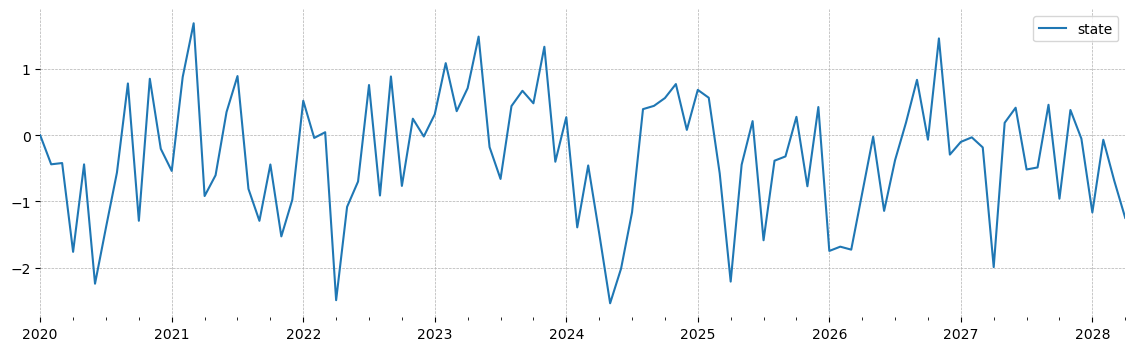

In [3]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
df.plot(ax=ax)
plt.show()

# Statsmodels

In [4]:
mod = sm.tsa.SARIMAX(endog=data, order=(1, 0, 1))
res = mod.fit(disp=0)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -132.552
Date:                Sun, 23 Jul 2023   AIC                            271.104
Time:                        15:47:49   BIC                            278.919
Sample:                             0   HQIC                           274.267
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6850      0.199      3.436      0.001       0.294       1.076
ma.L1         -0.4040      0.250     -1.619      0.105      -0.893       0.085
sigma2         0.8282      0.128      6.448      0.000       0.576       1.080
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 3.10
Prob(Q):                              0.63   Prob(JB):                         0.21
Heteroskedasticity (H):               0.63   Skew:                            -0.34
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# PyMC

Unlike the local level model, we don't need to explicitly estimate the inital covaraince matrix for an ARIMA model, because the model dynamics are stationary. Instead, we can solve a discrete lyapunov equation for the stationary covariance matrix $P^\star$:

$$TP^{\star} T^T - P^{\star} + R Q R^T = 0$$

Which is done automatically via an aesara implemention of the doubling algorithm. Note that this requires yet another scan op, bringing the total to 3. So while it's good for stability, it's not great for speed.

In [5]:
ss_mod = pmss.BayesianARMA(order=(1, 1), verbose=True)

Model successfully initialized! The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (2,), constraints: None, dims: ('state',)
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (1,), constraints: None, dims: ('ma_lag',)
	sigma_state -- shape: (1,), constraints: Positive, dims: ('observed_state',)


In [6]:
ss_mod.coords

{'state': ['data', 'state_1'],
 'state_aux': ['data', 'state_1'],
 'observed_state': ['data'],
 'observed_state_aux': ['data'],
 'shock': ['innovations'],
 'shock_aux': ['innovations'],
 'ar_lag': [1],
 'ma_lag': [1]}

In [7]:
ss_mod.param_dims

{'x0': ('state',),
 'sigma_state': ('observed_state',),
 'ar_params': ('ar_lag',),
 'ma_params': ('ma_lag',)}

In [8]:
with pm.Model(coords=ss_mod.coords) as arma_model:
    x0 = pm.Normal("x0", mu=0.0, sigma=1.0, dims=ss_mod.param_dims["x0"])
    state_sigmas = pm.HalfNormal("sigma_state", sigma=1.0, dims=ss_mod.param_dims["sigma_state"])

    rho = pm.TruncatedNormal(
        "ar_params", mu=0.0, sigma=0.5, lower=-1.0, upper=1.0, dims=ss_mod.param_dims["ar_params"]
    )
    theta = pm.Normal("ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ma_params"])

    ss_mod.build_statespace_graph(df, mode="JAX")

## Prior Predictive

### Unconditional

A note about what the states are, first of all. For an ARMA (1,1) model, the state space transition equation is:

$$ \begin{bmatrix} y_{t+1} \\ x_{t+1} \end{bmatrix} = 
    \begin{bmatrix}\rho & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} y_t \\ x_t \end{bmatrix} + 
    \begin{bmatrix} 1 \\ \theta \end{bmatrix} \varepsilon_{t+1}
    $$
    
Which, if you work out the matrix multiplications, gives two state equations:

$$\begin{align} y_{t+1} &= \rho y_t + x_t + \varepsilon_{t+1} \\
    x_{t+1} &= \theta \varepsilon_{t+1} \end{align}$$
    
So the two states we end up with are the modeled data ($y_{t+1}$), and the innovation series, scaled by $\theta$. To recover the estimated innovations, you would need to divide the second state by $\theta$. It is also possible to write it such that the innovations are "carried along", but it doubles the number of states required. This is probably fine for small values of p and q, but bad for larger ones, since the Kalman filter needs to invert a matrix of size $k \times k$ each iteration.

Anyway, we can two different types of trajectories in the priors. One is sharp and jagged, when rho/theta are large and negative. The other is smooth and meandering, when rho is positive and reasonable. When rho is very close to 1, we get the trajectories that wander out to +/- 20.

In [9]:
# with arma_model:
#     unconditional_prior = model.sample_unconditional_prior(
#         n_steps=100, n_simulations=10, prior_samples=500
#     )

In [10]:
# fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
# for idx, (axis, name) in enumerate(
#     zip(fig.axes, ["Observed State (Data)", "Hidden State (Innovations)"])
# ):
#     axis.plot(unconditional_prior[0][:, :, idx].T)
#     axis.set(title=name)

# fig.set_facecolor("w")
# fig.tight_layout()
# plt.show()

### Conditional

The conditional outputs for the kalman smoother and filter aren't as interesting for this model, because the process noise doesn't have full rank. That is, only the second state, associated with the MA process, has noise added. The result is that the first state noiselessly encodes the data. Let's have a look!

In [11]:
# with arma_model:
#     filtered_prior = model.sample_conditional_prior(
#         filter_output="filtered", n_simulations=10, prior_samples=500
#     )

# fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
# for idx, (axis, name) in enumerate(
#     zip(fig.axes, ["Observed State (Data)", "Hidden State (Innovations)"])
# ):
#     axis.plot(filtered_prior[:, :, idx].T, color="0.5", alpha=0.1)
#     axis.set(title=name)

# fig.set_facecolor("w")
# fig.tight_layout()
# plt.show()

We can ask for the kalman predictions, $\mathbb E\left [ x_{t+1} | \{y_\tau\}_{\tau=0}^{t} \right]$, which are a bit more interesting, by passing `filter_output = 'prediced'` to the `sample_conditional_prior` method

In [12]:
# with arma_model:
#     prior_pred = model.sample_conditional_prior(
#         filter_output="predicted", n_simulations=10, prior_samples=500
#     )

# fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
# for idx, (axis, name) in enumerate(
#     zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
# ):
#     axis.plot(prior_pred[:, :, idx].T, color="0.5", alpha=0.1)
#     if idx == 0:
#         axis.plot(data, color="tab:red")
#     axis.set(title=name)

# fig.set_facecolor("w")
# fig.tight_layout()
# plt.show()

# Estimation

Finally on to actually fitting the model. There are ways to speed things up a bit. We are using stationary covariance initialization, which saves us from estimating the intial covaraince matrix. PyMC Statespace also offers different flavors of Kalman Filter, some with some built in speedups (`steady_state`). 

For now we'll just go with the standard filter. There is a separate notbook explaining and comparing the different filtering choices.

In [13]:
with arma_model:
    idata = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:07.399857
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:26.244767
Transforming variables...
Transformation time =  0:00:06.583722


In [14]:
idata.sample_stats.diverging.sum().values

array(0)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


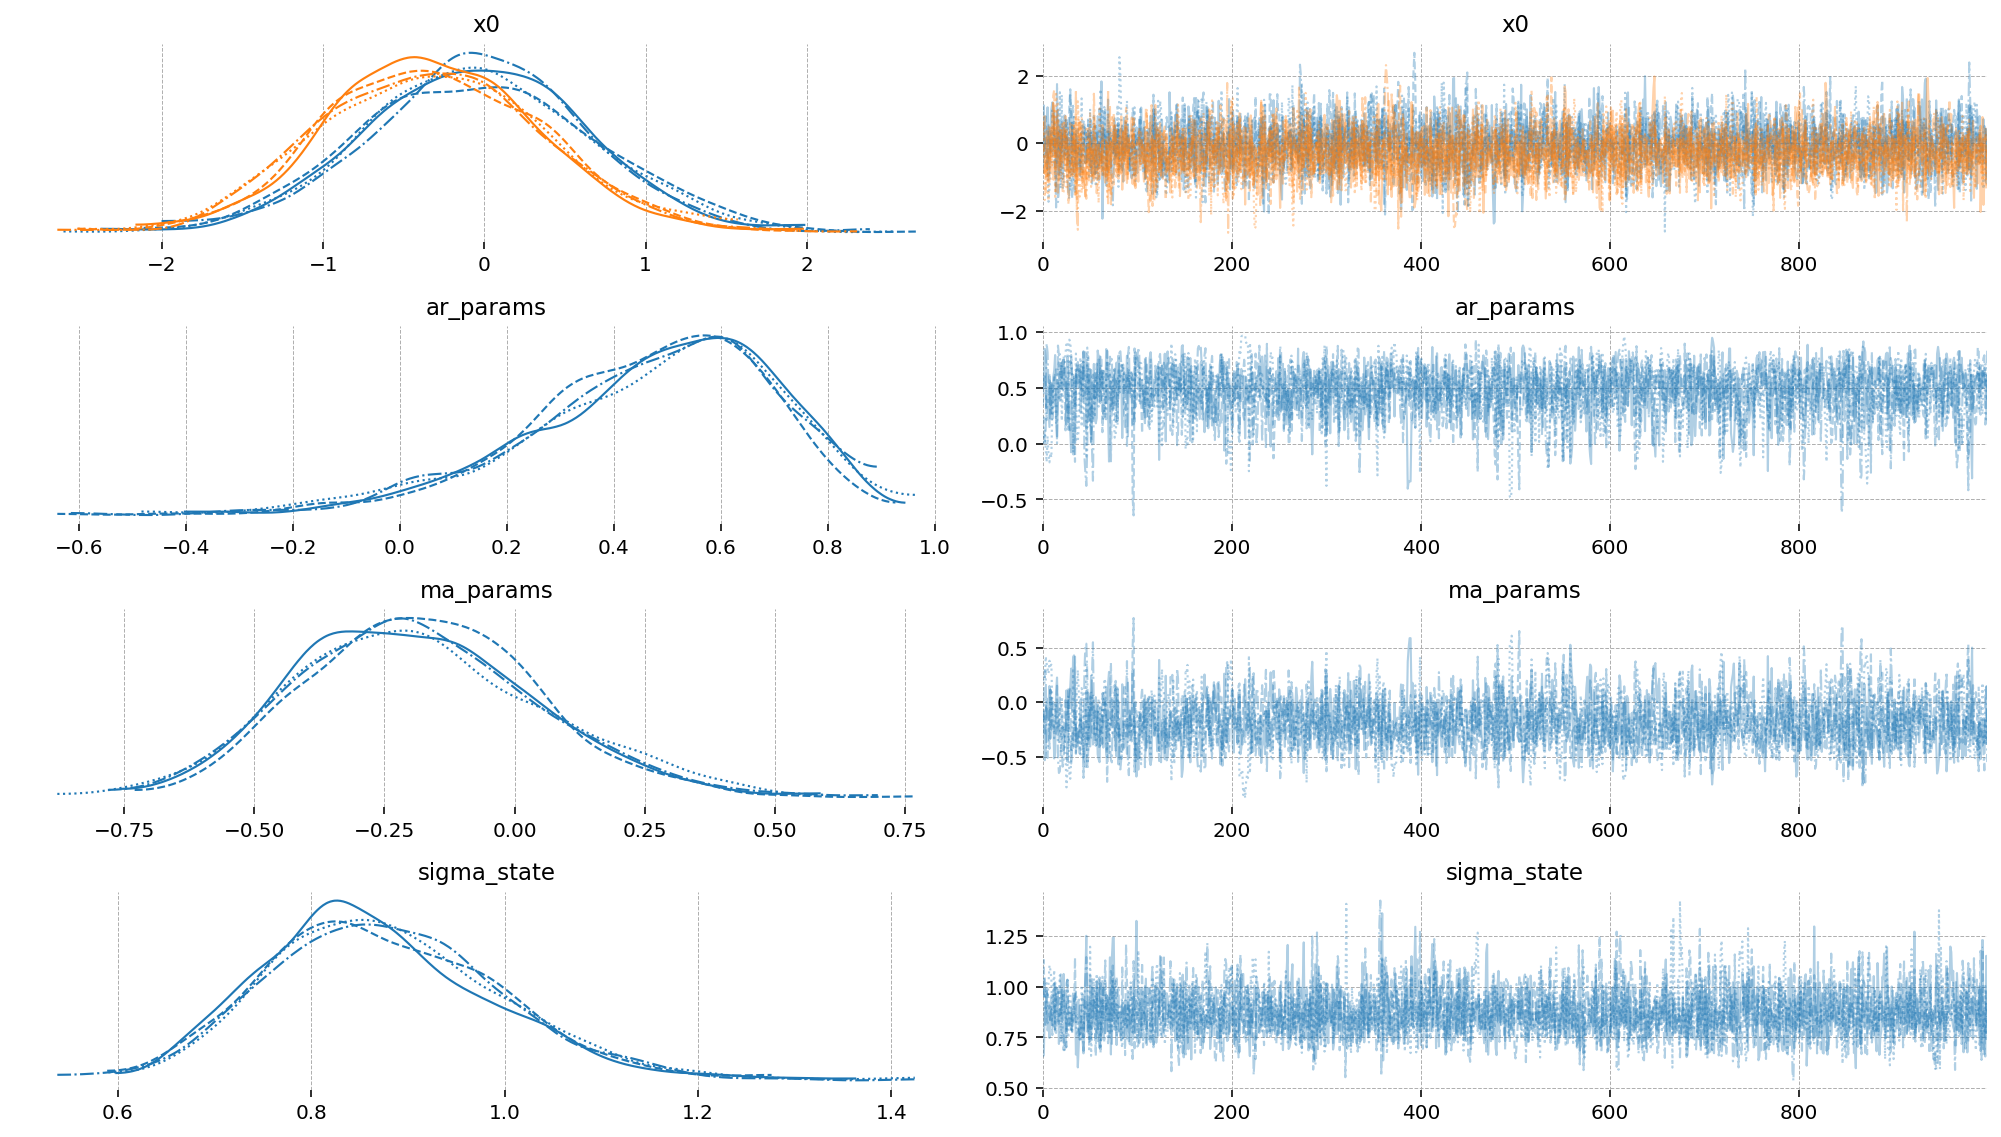

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(14, 8))
az.plot_trace(idata, var_names=ss_mod.param_names, axes=ax)
fig.tight_layout()
plt.show()

Posterior estimates are reasonable, and the true value is contained in the 94% HDI in each case. Looks like the ML estimator did a bit better, but we also estimated 4 more parameters than it did (2 initial states, plus 2 initial covariances!)

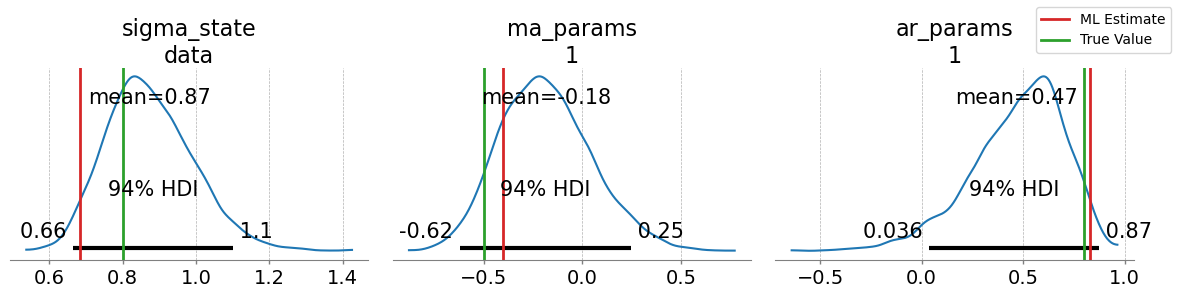

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3), dpi=100)
az.plot_posterior(idata, var_names=["sigma_state", "ma_params", "ar_params"], ax=ax)
ax[0].axvline(res.params[0], color="tab:red", lw=2, label="ML Estimate")
ax[1].axvline(res.params[1], color="tab:red", lw=2)
ax[2].axvline(res.params[2], color="tab:red", lw=2)

ax[0].axvline(0.8, color="tab:green", lw=2, label="True Value")
ax[1].axvline(-0.5, color="tab:green", lw=2)
ax[2].axvline(0.8, color="tab:green", lw=2)


fig.set(facecolor="white")
fig.tight_layout()
fig.legend()
plt.show()

# Posterior Predictive

## Unconditional

In [17]:
unconditional_post = ss_mod.sample_unconditional_posterior(
    idata, steps=100, use_data_time_dim=False
)
post = az.extract(unconditional_post, "posterior_predictive").posterior_latent

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F745B4C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [posterior_combined]


Notice how there's no more trajectories that diverge away from the mean. The posterior rules out values of $\rho$ close to 1

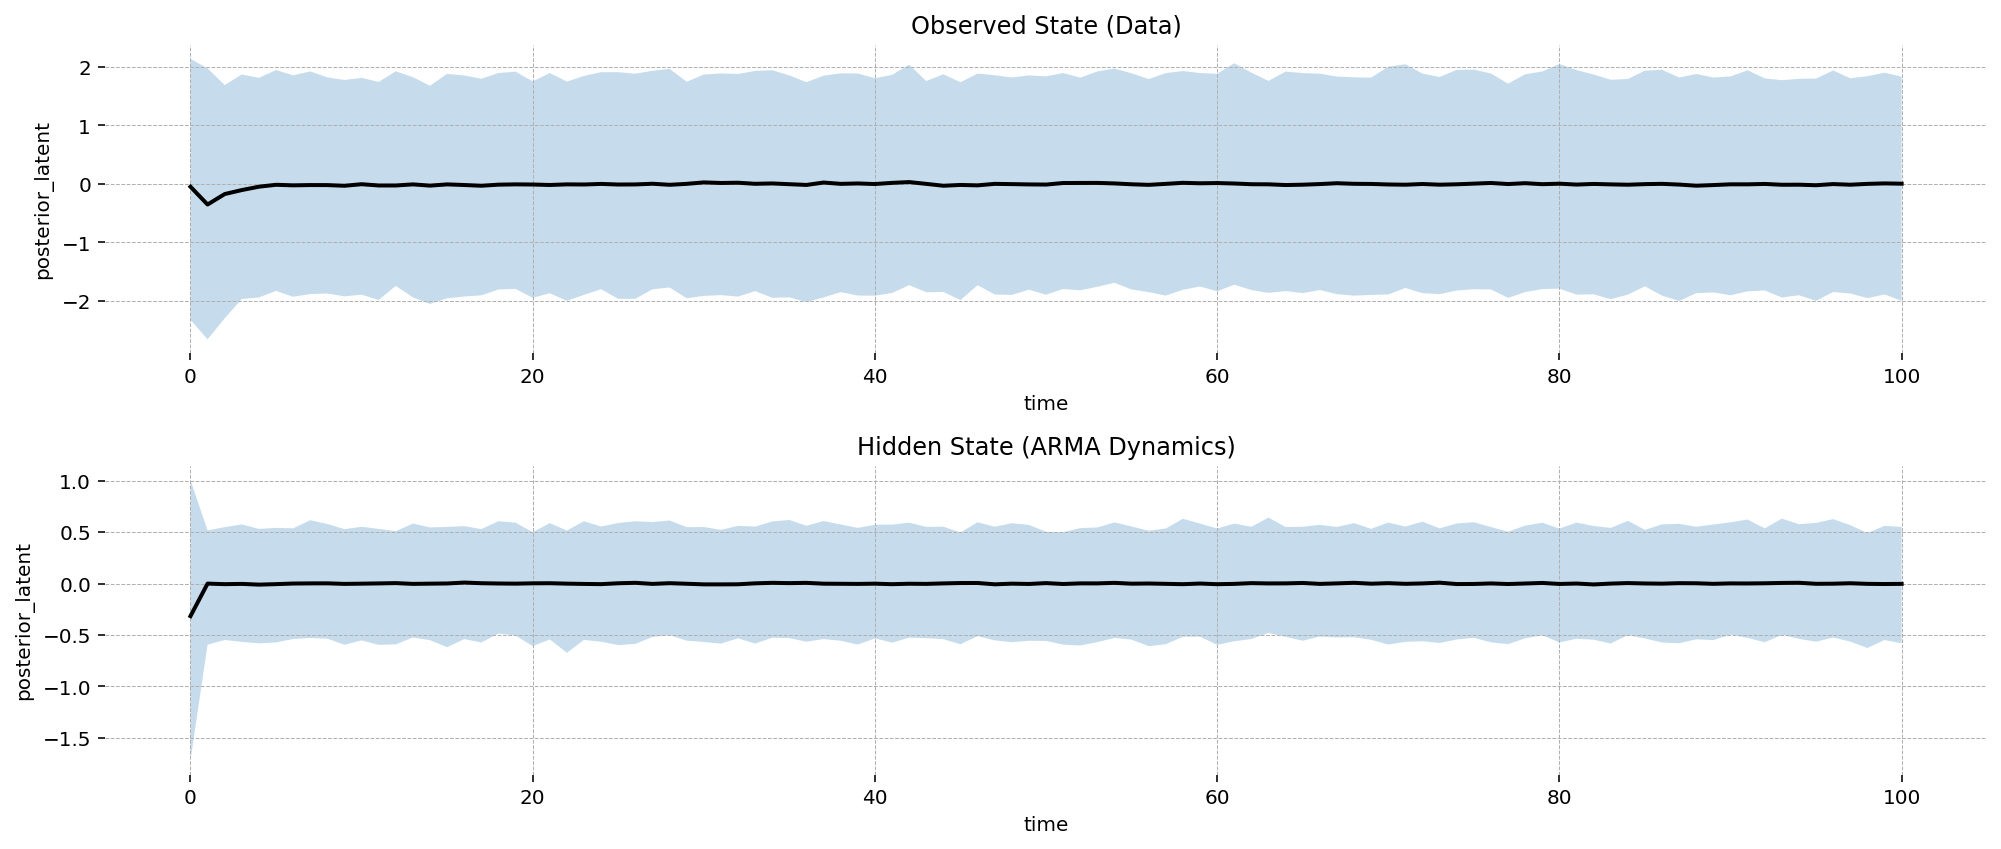

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
hdi = az.hdi(unconditional_post.posterior_predictive).posterior_latent

for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
):
    post.isel(state=idx).mean(dim="sample").plot.line(
        x="time", ax=axis, color="k", lw=2, add_legend=False
    )
    axis.fill_between(hdi.coords["time"], *hdi.isel(state=idx).values.T, alpha=0.25)
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

## Conditional

In [19]:
post_pred = ss_mod.sample_conditional_posterior(idata, filter_output="predicted")
post = az.extract(post_pred, "posterior_predictive").predicted_posterior

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F6844120>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [predicted_posterior]


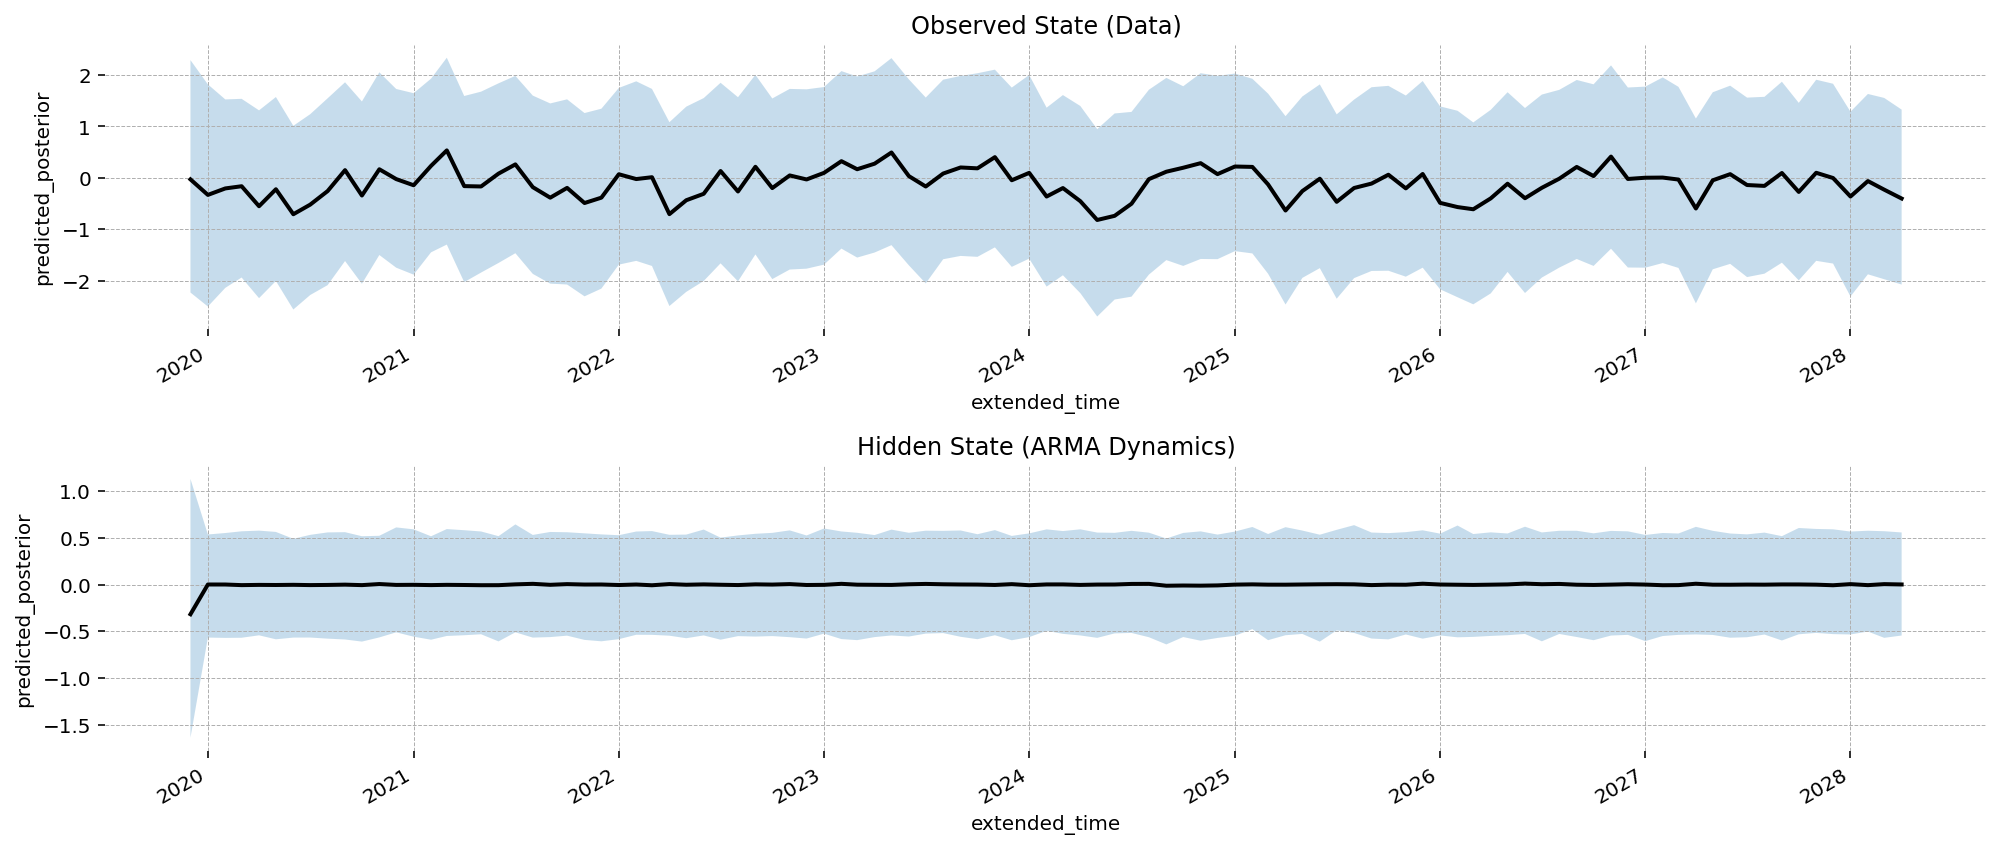

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
hdi = az.hdi(post_pred.posterior_predictive).predicted_posterior

for idx, (axis, name) in enumerate(
    zip(fig.axes, ["Observed State (Data)", "Hidden State (ARMA Dynamics)"])
):
    post.isel(state=idx).mean(dim="sample").plot.line(
        x="extended_time", ax=axis, color="k", lw=2, add_legend=False
    )
    axis.fill_between(hdi.coords["extended_time"], *hdi.isel(state=idx).values.T, alpha=0.25)
    axis.set(title=name)

fig.set_facecolor("w")
fig.tight_layout()
plt.show()

# Predictions Compared

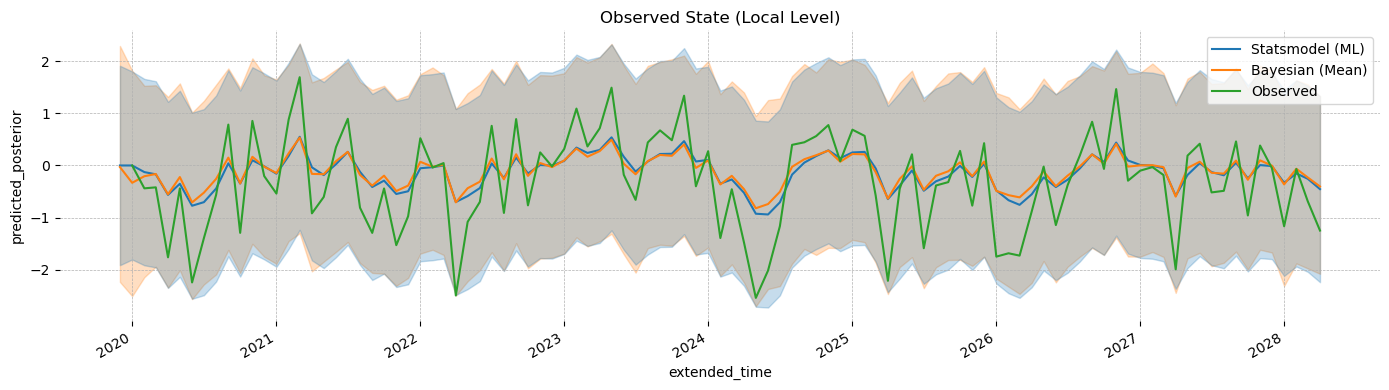

In [21]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
hdi = az.hdi(post_pred.posterior_predictive).predicted_posterior

extended_index = df.index.shift(-1).union(df.index)

ax.plot(extended_index, res.states.predicted[:, 0], label="Statsmodel (ML)")
post.mean(dim="sample").isel(state=0).plot.line(x="extended_time", label="Bayesian (Mean)")
ax.fill_between(
    df.index.shift(-1).union(df.index),
    *hdi.isel(state=0).values.T,
    alpha=0.25,
    color="tab:orange",
)

ml_mu = res.states.predicted[:, 0]
ml_var = res.states.predicted_cov.reshape(-1, 2, 2)[:, 0, 0]

ax.fill_between(
    extended_index,
    ml_mu - 1.96 * np.sqrt(ml_var),
    ml_mu + 1.96 * np.sqrt(ml_var),
    alpha=0.25,
    color="tab:blue",
)

ax.plot(df.index, df.values, label="Observed")
ax.set(title="Observed State (Local Level)")
ax.legend()

fig.set(facecolor="white")
fig.tight_layout()
plt.show()

## Forecasting

In [22]:
post_pred = ss_mod.sample_conditional_posterior(idata, filter_output="smoothed")
post = az.extract(post_pred, "posterior_predictive").smoothed_posterior

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F790C4A0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [smoothed_posterior]


In [23]:
idata_forecast = ss_mod.forecast(idata, start=df.index[-1], periods=10, filter_output="smoothed")
forecast = az.extract(idata_forecast, "posterior_predictive")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F7C5BD80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


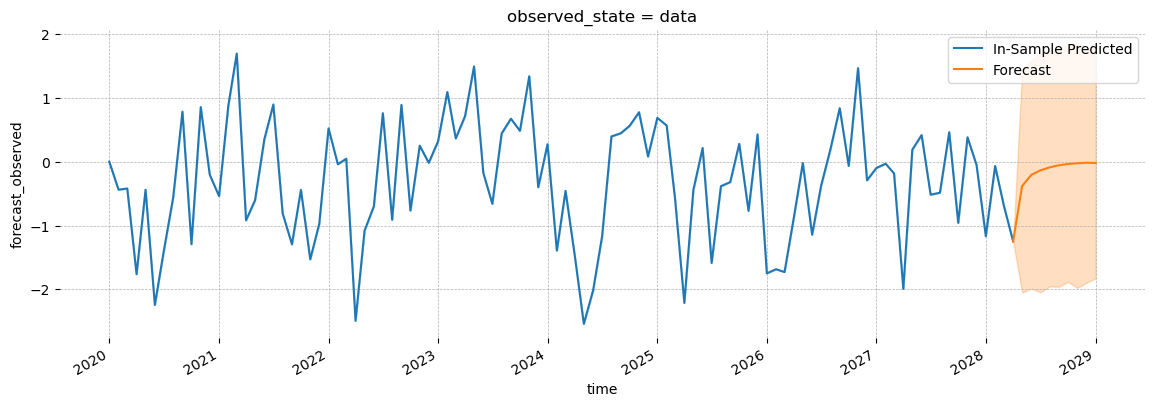

In [24]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=100)
hdi_in = az.hdi(post_pred.posterior_predictive).smoothed_posterior
hdi_forecast = az.hdi(idata_forecast.posterior_predictive).forecast_observed

post.mean(dim="sample").isel(state=0).plot.line(
    x="time", label="In-Sample Predicted", add_legend=False
)
ax.fill_between(
    df.index,
    *hdi_in.isel(state=0).values.T,
    alpha=0.25,
    color="tab:blue",
)

forecast.mean(dim="sample").forecast_observed.isel(observed_state=0).plot.line(
    x="time", label="Forecast", add_legend=False
)
ax.fill_between(
    forecast.coords["time"].values,
    *hdi_forecast.isel(observed_state=0).values.T,
    alpha=0.25,
    color="tab:orange",
)

ax.legend()
plt.show()

## Procupine Graph

In [25]:
idatas = []
for date in df.index[10::10]:
    idata_forecast = ss_mod.forecast(idata, start=date, periods=5, filter_output="smoothed")
    idatas.append(idata_forecast)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F6D4AF80>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F6643A00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F6524820>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F6B951C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F68458C0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F6A402E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC18BE10120>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC18A042EA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC18A928040>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [forecast_combined]


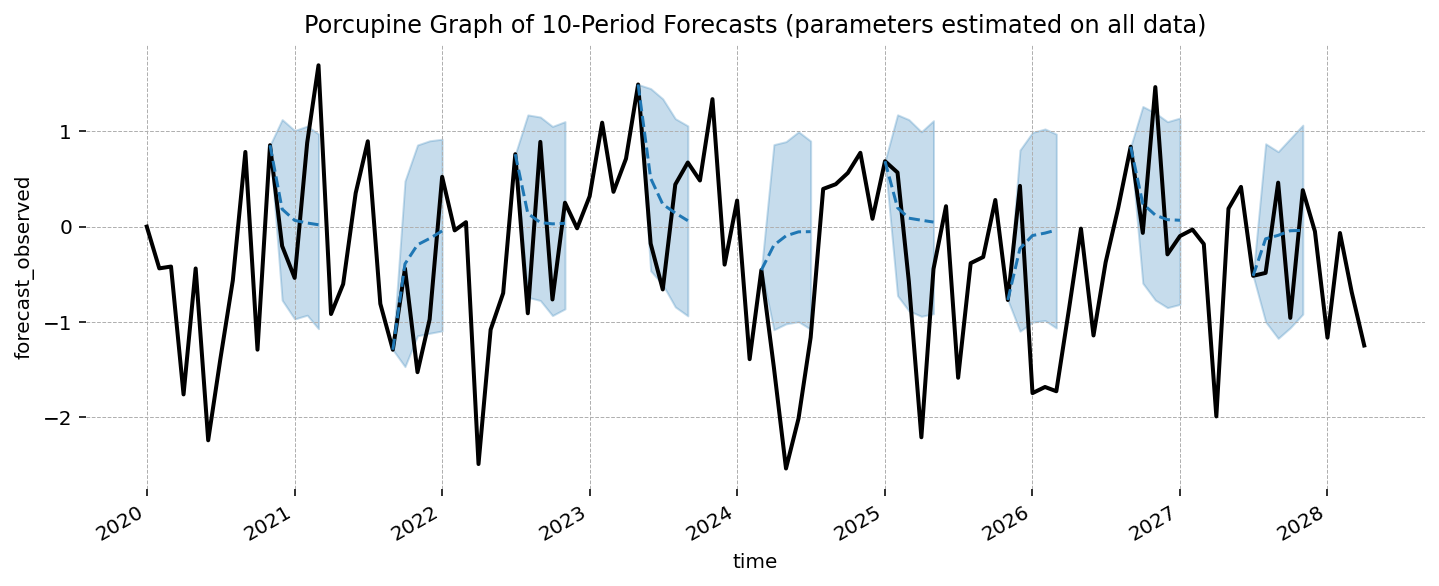

In [26]:
fig, ax = plt.subplots()
ax.plot(df.index, df.values, lw=2, c="k")

for idata_forecast in idatas:
    forecast = az.extract(idata_forecast, "posterior_predictive")
    hdi_forecast = az.hdi(idata_forecast.posterior_predictive, hdi_prob=0.69).forecast_observed

    mean = forecast.mean(dim="sample").forecast_observed.isel(observed_state=0)
    mean.plot.line(x="time", color="tab:blue", ls="--")
    ax.fill_between(
        hdi_forecast.coords["time"].values,
        *hdi_forecast.isel(observed_state=0).values.T,
        alpha=0.25,
        color="tab:blue"
    )
ax.set_title("Porcupine Graph of 10-Period Forecasts (parameters estimated on all data)")
plt.show()

## Interpretable ARMA

In addition to the usual formulation, there's also an "intrepretable" formulation of the ARMA model. It has significantly more states, which makes it a bad choice if speed is critical. But for a smallish model on smallish data, it lets us directly recover the innovation trajectory.

We can also add measurement error to the model, in case we have some reason to doubt the data. We'll also show off the missing data interpolation ability of the state space model.

In [27]:
ss_mod = pmss.BayesianARMA(
    order=(1, 1), state_structure="interpretable", measurement_error=True, verbose=True
)

Model successfully initialized! The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (2,), constraints: None, dims: ('state',)
	ar_params -- shape: (1,), constraints: None, dims: ('ar_lag',)
	ma_params -- shape: (1,), constraints: None, dims: ('ma_lag',)
	sigma_state -- shape: (1,), constraints: Positive, dims: ('observed_state',)
	sigma_obs -- shape: (1,), constraints: Positive, dims: ('observed_state',)


In [28]:
ss_mod.state_names

['data', 'innovations']

In [29]:
with pm.Model(coords=ss_mod.coords) as arma_model:
    x0 = pm.Normal("x0", mu=0.0, sigma=1.0, dims=ss_mod.param_dims["x0"])
    state_sigmas = pm.HalfNormal("sigma_state", sigma=1.0, dims=ss_mod.param_dims["sigma_state"])
    obs_sigmas = pm.HalfNormal("sigma_obs", sigma=1.0, dims=ss_mod.param_dims["sigma_obs"])
    rho = pm.TruncatedNormal(
        "ar_params", mu=0.0, sigma=0.5, lower=-1.0, upper=1.0, dims=ss_mod.param_dims["ar_params"]
    )
    theta = pm.Normal("ma_params", mu=0.0, sigma=0.5, dims=ss_mod.param_dims["ma_params"])

    theta = ss_mod._gather_required_random_variables()
    ss_mod.build_statespace_graph(df, mode="JAX")

    idata = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:08.640555
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:27.522244
Transforming variables...
Transformation time =  0:00:05.157789


In [30]:
post_pred = ss_mod.sample_conditional_posterior(idata, filter_output="smoothed")
post = az.extract(post_pred, "posterior_predictive").smoothed_posterior

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FC0F74275A0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [smoothed_posterior]


We can see that the smoother output for the observed Data variable is no longer a perfect fit and has some posterior uncertainty resulting from measurement error. The hidden state is now the exact innovation series, unscaled by theta or lagged, which makes it easier to interpret, as advertised.

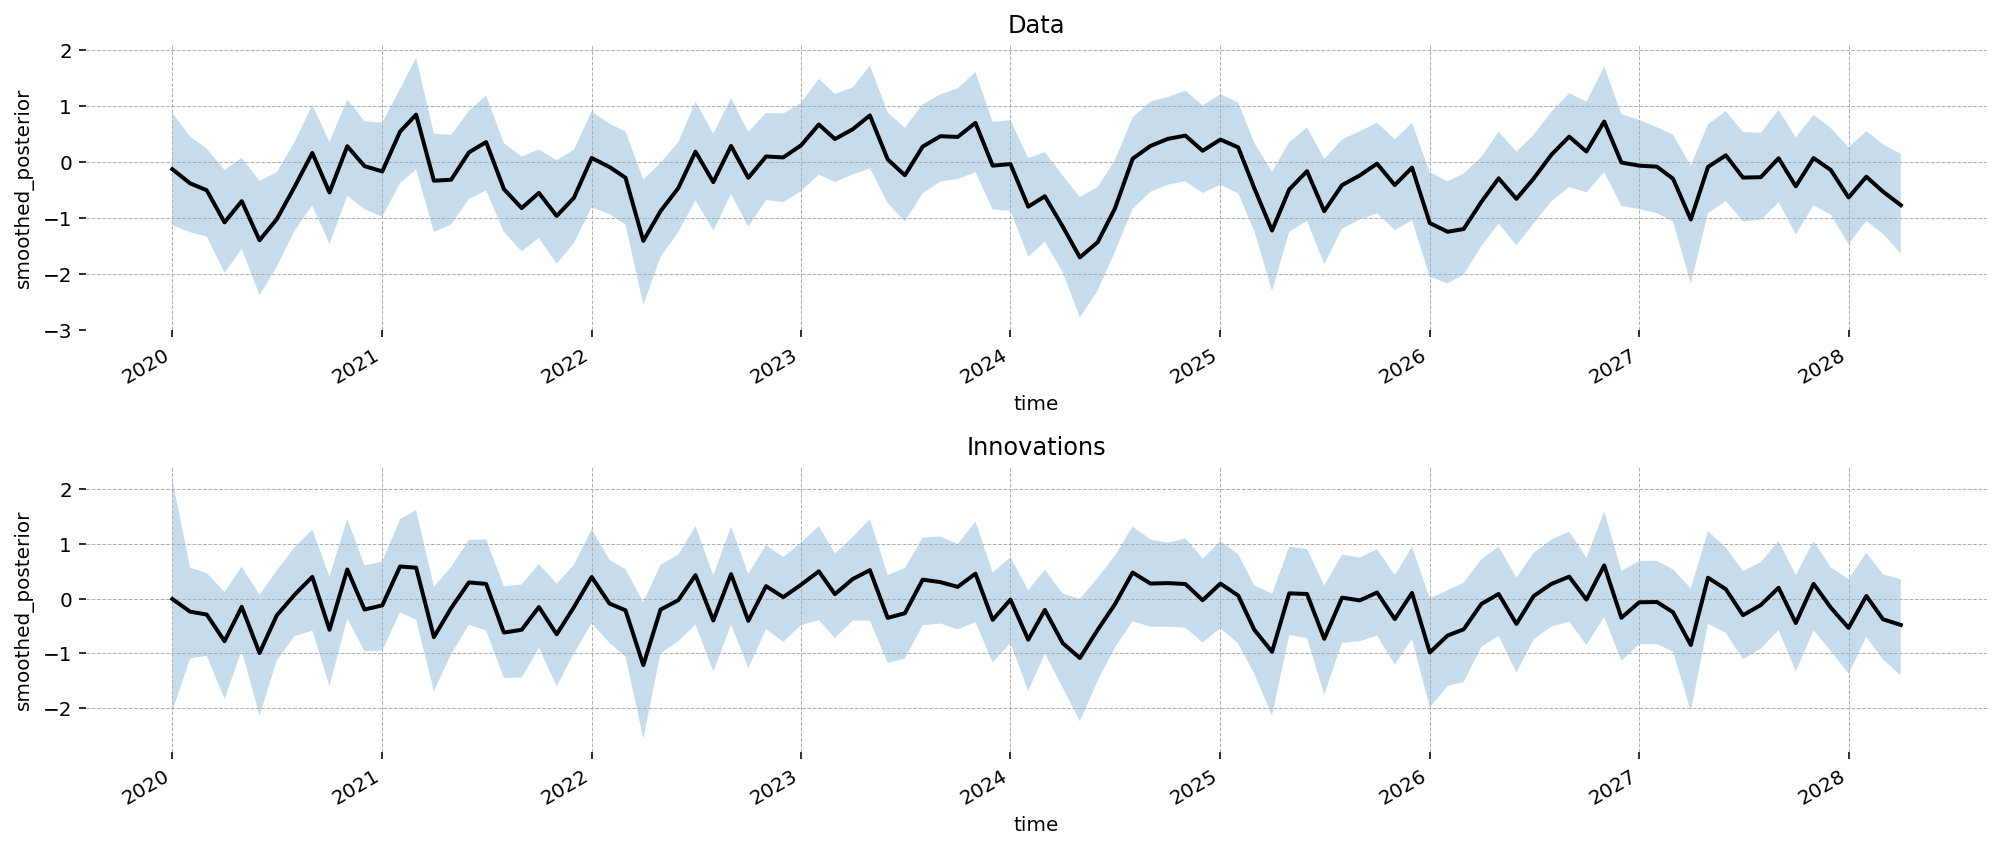

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6), dpi=144)
hdi = az.hdi(post_pred.posterior_predictive).smoothed_posterior

for idx, (axis, name) in enumerate(zip(fig.axes, ss_mod.state_names)):
    post.sel(state=name).mean(dim="sample").plot.line(
        x="time", ax=axis, color="k", lw=2, add_legend=False
    )
    axis.fill_between(hdi.coords["time"], *hdi.isel(state=idx).values.T, alpha=0.25)
    axis.set(title=name.title())

fig.set_facecolor("w")
fig.tight_layout()
plt.show()